# Section 10 - Transfer Learning - PyTorch

### When to use ***Transfer Leaning***?
  - When you don't have ***enough labelled data***;
  - When an effective ***pre-trained model already exists***;
  - Wen you don't have much time to train a model;
  - When you don't have enough computational power to train from scratch.

> ### In this task the ***features extractor layers(Convolutional Layers)*** are freezed, so its weights will not be updated during the training process. On the other hand, the classifier(Fully Connected Layer - Neural Network) will stay dynamic, so its weights will be updated during the training process because the classifier will choose witch features, from pre-trained model, are important to classifie a specific dataset.  

# PyTorch Instalation

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

## Initializing GPU Usage

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 42.50 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [0]:
!ls

ants_and_bees  sample_data


In [0]:
!ls ants_and_bees

train  val


In [0]:
!ls ants_and_bees/train

ants  bees


In [0]:
!ls ants_and_bees/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

## Making and Configuring the dataset

> ### Some explanations...
> - ***Tensors for images***: [(BatchIndex, NumberOfChannels, ImagesHeight, ImagesWidth)] -> [(BI, C, H, W)].
> - ***transforms.Resize((28,28))***: 
> - ***transforms.ToTensor()***: Convert the numpy array, in this case an image, to a float tensor format;
> - ***transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))***: Normalize the values of each channel of the tensor image. The first set of brackets is the mean and in the second set of brackets is the standard deviation. For images with 3 channels of color.
> - ***transforms.RandomHorizontalFlip()***: Horizontal flip the given PIL Image randomly with a given probability.
> - ***transforms.RandomRotation(10)***: Rotate the image by angle.
> - ***transforms.RandomAffine(0, shear=10, scale=(0.8,1.2))***: Random affine transformation of the image keeping center invariant.
> - ***transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)***: Randomly change the brightness, contrast and saturation of an image.


> - ***training_dataset and validation_dataset***: Load the train and validation MNIST dataset from torchvision datasets. The load is done downloading the dataset and saving in the root directory;
> - ***training_loader and validation_loader***: A training loader and validation loader are what we use to specify the training batches. In MNIST dataset, there are 60000 images for training. It can be too much images to load at once in the computer memory, so it is better to use image batches in the training process. For every Epoch, is performed a singles pass through the entire dataset and it occurs in batches;
> - ***NumberOfBatches*** = DatasetSize/BatchSize;
> - ***datasets.ImageFolder*** = Load a custom dataset ina a custom directory/folder;
> - ***datasets.MNIST*** = Load a dataset already configured from PyTorch.


In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(), # Data Augmentation
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), # Data Augmentation
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1), # Data Augmentation
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# datasets.ImageFolder = Load a custom dataset ina a custom directory/folder
training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train) 
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform) 

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [0]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
# This function converts an image from tensor format to numpy format.
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
!pip install Pillow==4.0.0

     |████████████████████████████████| 5.6MB 4.8MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
classes = ('ant', 'bee')

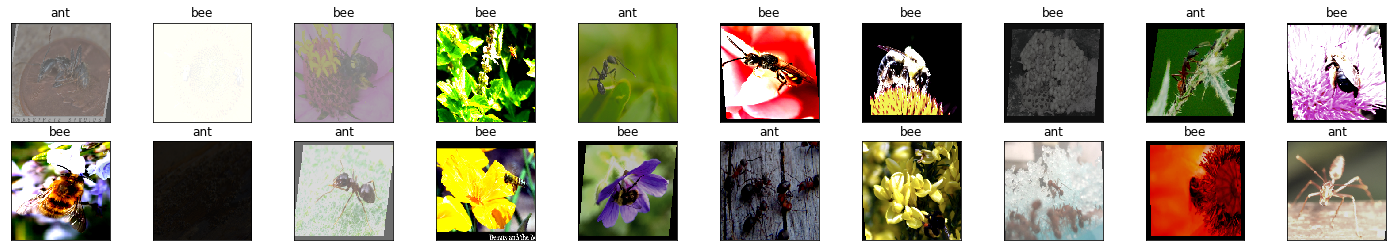

In [0]:
# Plot some images from the first batch.
# iter() -> Create an object that allows us to go through the iterable training_loader, one element at a time. 
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

## Loading pre-trained VGG16 model - Loading the VGG16's weights

In [0]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 69.0MB/s]


In [0]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in model.features.parameters(): # Loop for all parameters in feature extractor(Convolutional Layers) portion of the model.
  param.requires_grad = False # 'requires_grad = False' means that the gradient will not be computed for feature extractor(Convolutional Layers) and the weights will not be updated in this portions of the model.

In [0]:
# The VGG16 model is configured for 1000 classes and in the dataset is only two classes: Ants and Bees. So the number of classes must be modified.
# For this, other last layer will be made(configured) and updated in the model structure.
import torch.nn as nn

n_inputs = model.classifier[6].in_features # Retrieve the number of inputs of the last layer(Fully Connected Layer).
last_layer = nn.Linear(n_inputs, len(classes)) # Creating a new Fully Connected Layer as a last layer of the model.
model.classifier[6] = last_layer # Updating the last layer of the model with the new one created on line above.
model.to(device) # Putting the model on GPU.
print(model.classifier[6].out_features)
print(model.classifier[6])
print(model)

2
Linear(in_features=4096, out_features=2, bias=True)
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Ma

> ### The ***CrossEntropyLoss*** is used for ***MULTICLASS*** classification problems. It is a combination between ***log_softmax*** and ***NLLLoss***.

> ### ***OBS***: When the criterion used is the CrossEntropyLoss, in the end of the CNN, an Activation Function is not used. The last layer is not an Activation Function. The inputs for CrossEntropyLoss are the raw scores and internaly the Softmax Activation Function is applied.

In [0]:
criterion = nn.CrossEntropyLoss()

> ### The Adam Optimization Algorithm is a combination of two other extensions of Stochastic Gradiente Descent: *Adagrad* and *RMSprop*. The Adam Optimization Algorithm computes adaptive learning rates for each parameters instead of keep the same learning rates for all parameters.

> ### ***Small Datasets*** -> Decrease the Learning Rate
  - There are few samples to learn, so small steps is better for the learning process. 

> ### ***Large Datasets*** -> Increase the Learning Rate
  - There are many samples to learn, so a little bit bigger steps is better for the learning process. 


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

## Executing the ***TRAIN*** step

In [0]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0284, acc 0.7090 
validation loss: 0.0160, validation acc 0.8758 
epoch : 2
training loss: 0.0143, acc 0.8811 
validation loss: 0.0140, validation acc 0.9216 
epoch : 3
training loss: 0.0138, acc 0.9057 
validation loss: 0.0131, validation acc 0.9346 
epoch : 4
training loss: 0.0104, acc 0.8975 
validation loss: 0.0191, validation acc 0.9216 
epoch : 5
training loss: 0.0157, acc 0.8648 
validation loss: 0.0186, validation acc 0.9281 


> ## *Overfitting*: is when the model starts to memorize the training dataset but starts to fail in generalize to new data.
> ### If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.

> ### Ways to prevent Overfitting of the model:
- ***Hyperparameter Tunning***: Adjusting some Hyperparameters like:
  - ***Learning Rate***
  - ***Data Augmentation***: This is the process by witch we create new data for our model to use during training process. This is done by taking our the existing training dataset and transforming or altering the images in useful ways to create new images. 
  - ***Increasing the number of Convolution Layers***
- ***Use Dropout Technique***: Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase. This force the remaining hidden layers and neurons to learn(weight updates) and result in a good performance. This technique helps in the generalization of the model.
  - ***Dropout Layers(nn.Dropout())***: Is used in between layers that have high number of parameters because this high parameters layers are more likely to overfit and memorize the training data.
- ***Decrease the kernel's size***: Decreasing the kernel's size there will be less weights to update.

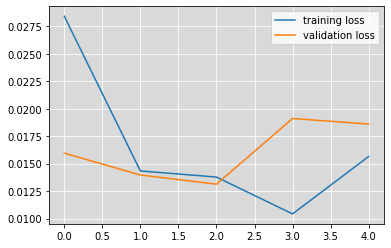

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)


plt.legend()
# If the epoch number is increased too much, the training loss starts to become higher than the validation loss, this is a signal that the model starts to Overfitting.
# A model with Overfitting is when the model starts to memorize the training dataset but starts to fail in generalize to new data.

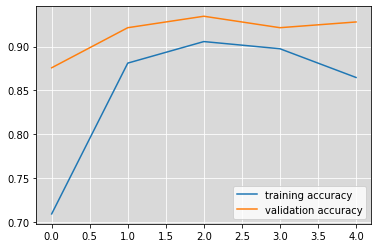

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')

ax = plt.gca()
ax.set_facecolor((0.85, 0.85, 0.85))
plt.grid(color='w', linestyle='solid')
ax.set_axisbelow(True)

plt.legend()

## Executing the ***PREDICT*** step of the CNN

> ### For this step, an image from the internet is downloaded and submitted to the model as an image test. 



In [0]:
!pip3 install pillow==4.0.0

In [0]:
import PIL.ImageOps

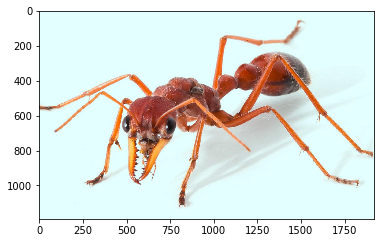

In [0]:
import requests
from PIL import Image

url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

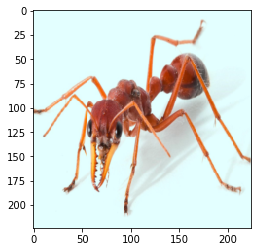

In [0]:
img = transform(img) 
plt.imshow(im_convert(img))

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


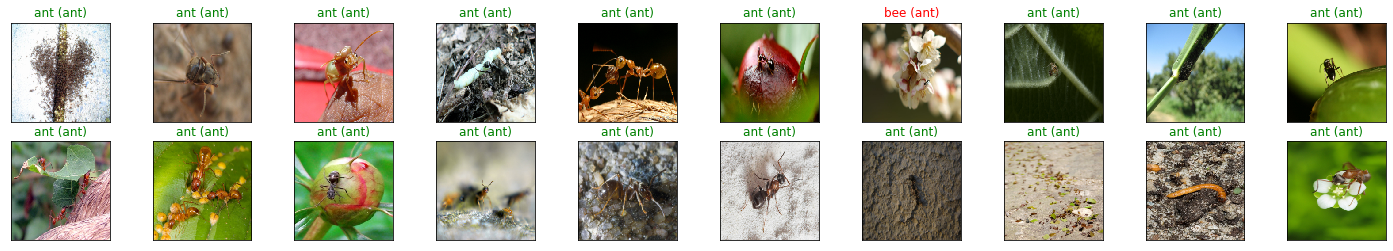

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))